In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [22]:

# --- 1. Simulation Function ---
def simulate_black_hole_lightcurve(fs, fc, fm, qpo_amplitude, duration,
                                   noise_mean=0, noise_std=0.5,
                                   include_qpo=True, modulation_index=0.5):
    """
    Simulate a black hole light curve with stochastic noise and an amplitude-modulated QPO signal.

    Parameters:
        fs : int
            Sampling frequency (Hz)
        fc : float
            Carrier frequency (Hz) for QPO
        fm : float
            Modulating frequency (Hz) for QPO
        qpo_amplitude : float
            Amplitude of the carrier signal (QPO)
        duration : float
            Duration of lightcurve (seconds)
        noise_mean : float
            Mean of the Gaussian noise
        noise_std : float
            Standard deviation of the Gaussian noise
        include_qpo : bool
            Whether to include the QPO signal
        modulation_index : float
            Modulation index for AM signal

    Returns:
        t : np.ndarray
            Time array
        flux : np.ndarray
            Normalized flux array
    """
    # Time array
    t = np.arange(0, duration, 1/fs)

    # White noise
    white_noise = np.random.normal(noise_mean, noise_std, size=len(t))
    white_noise = np.exp(white_noise)

    if include_qpo and qpo_amplitude > 0:
        # Modulating signal
        msg = qpo_amplitude * np.cos(2 * np.pi * fm * t)

        # Carrier signal
        carrier = qpo_amplitude * np.cos(2 * np.pi * fc * t)

        # AM QPO signal
        qpo = carrier * (1 + modulation_index * msg / qpo_amplitude)
    else:
        qpo = 0

    # Combine noise and QPO signal
    flux = white_noise + qpo

    # Normalize
    flux = (flux - np.mean(flux)) / np.std(flux)

    return t, flux

In [27]:

# --- 2. Dataset Generator for a Given Amplitude ---
def generate_dataset_for_amplitude(amp, output_dir, num_samples=2000, fs=100, seq_length=512, modulation_index=0.5):
    os.makedirs(output_dir, exist_ok=True)

    dataset = []
    labels = []

    duration = seq_length / fs  # duration to match 512 samples

    for _ in range(num_samples // 2):
        fc = np.random.uniform(0.01, 1.0)
        fm = np.random.uniform(0.005, 0.1)

        t, flux_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=True, modulation_index=modulation_index)
        _, flux_non_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=False, modulation_index=modulation_index)

        dataset.append(flux_qpo[:seq_length].reshape(-1, 1))     # (512, 1)
        labels.append(1)

        dataset.append(flux_non_qpo[:seq_length].reshape(-1, 1))  # (512, 1)
        labels.append(0)

    dataset = np.array(dataset)  # shape (num_samples, 512, 1)
    labels = to_categorical(np.array(labels), 2)

    np.savez_compressed(os.path.join(
        output_dir, 'data.npz'), X=dataset, y=labels)

In [28]:
# --- 3. Model Builder ---
def build_model():
    model = Sequential([
        Input(shape=(512, 1)),
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.5),

        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.5),

        Bidirectional(LSTM(32)),
        Dropout(0.5),

        Dense(32, activation='relu'),
        Dropout(0.4),

        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=5e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# --- 1. Plot Accuracy ---
def plot_accuracy(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 2. Plot Loss ---
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 3. Confusion Matrix ---
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test, verbose=0)
    y_true = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=['No QPO', 'QPO'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    return y_true, y_pred

# --- 4. ROC Curve  ---
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


🚀 Training on amplitude: 0.0
Epoch 1/50
13/13 - 14s - 1s/step - accuracy: 0.4837 - loss: 0.7617 - val_accuracy: 0.4875 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 2/50
13/13 - 10s - 791ms/step - accuracy: 0.5025 - loss: 0.7232 - val_accuracy: 0.5075 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 3/50
13/13 - 11s - 861ms/step - accuracy: 0.5325 - loss: 0.7105 - val_accuracy: 0.4775 - val_loss: 0.6935 - learning_rate: 5.0000e-04
Epoch 4/50
13/13 - 11s - 863ms/step - accuracy: 0.5263 - loss: 0.7073 - val_accuracy: 0.4675 - val_loss: 0.6936 - learning_rate: 2.5000e-04
Epoch 5/50
13/13 - 12s - 887ms/step - accuracy: 0.5006 - loss: 0.7205 - val_accuracy: 0.4650 - val_loss: 0.6937 - learning_rate: 2.5000e-04
Epoch 6/50
13/13 - 11s - 858ms/step - accuracy: 0.4938 - loss: 0.7116 - val_accuracy: 0.4675 - val_loss: 0.6939 - learning_rate: 1.2500e-04


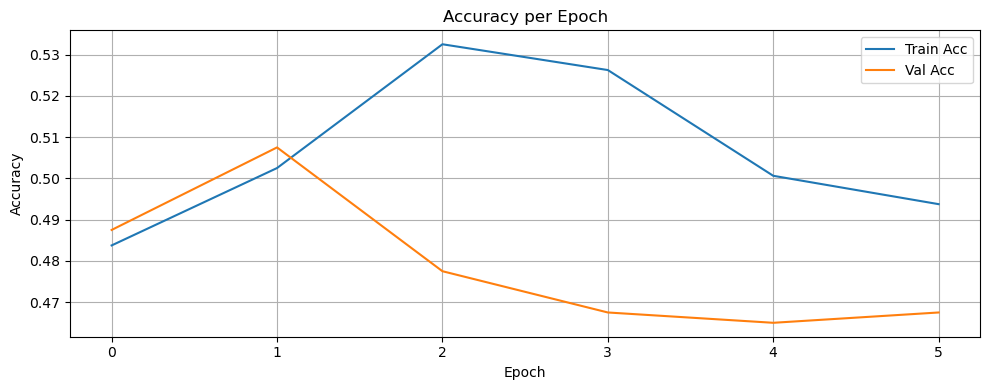

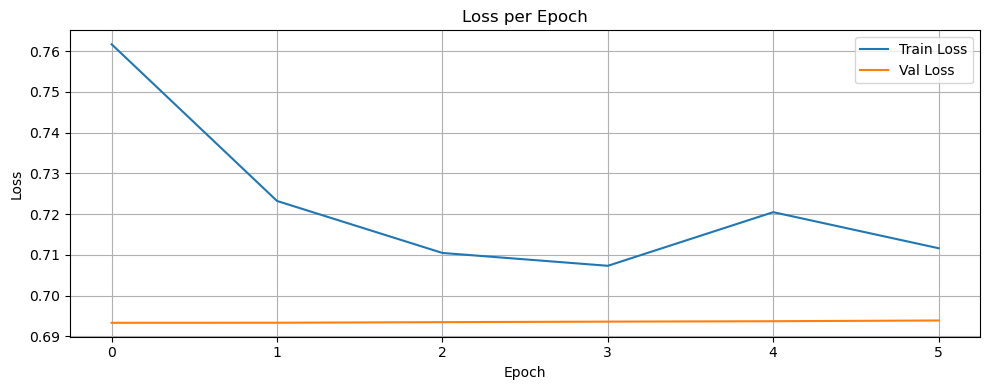

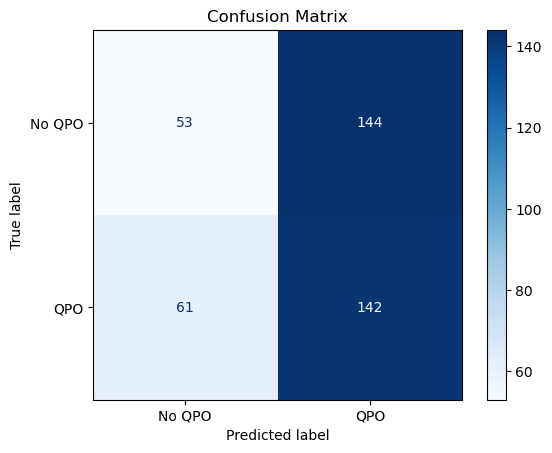

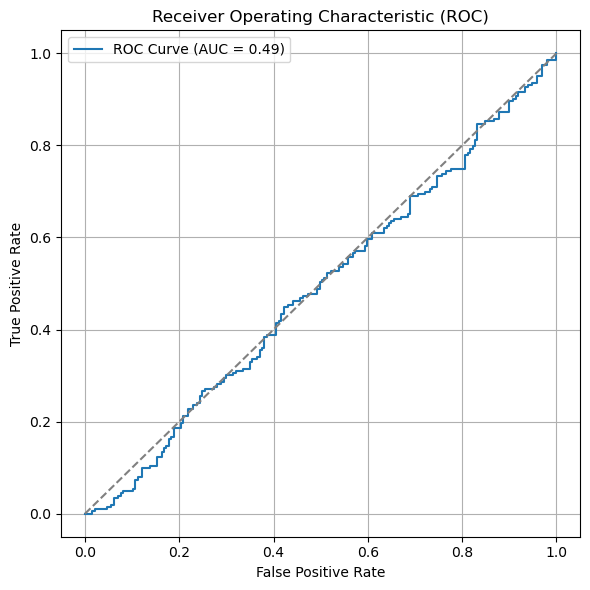

✅ Amplitude 0.0: Best Val Accuracy = 0.5075

🚀 Training on amplitude: 0.2
Epoch 1/50
13/13 - 14s - 1s/step - accuracy: 0.6488 - loss: 0.6417 - val_accuracy: 0.8225 - val_loss: 0.6652 - learning_rate: 5.0000e-04
Epoch 2/50
13/13 - 11s - 821ms/step - accuracy: 0.7775 - loss: 0.5160 - val_accuracy: 0.7900 - val_loss: 0.6354 - learning_rate: 5.0000e-04
Epoch 3/50
13/13 - 11s - 816ms/step - accuracy: 0.8288 - loss: 0.4351 - val_accuracy: 0.7700 - val_loss: 0.6013 - learning_rate: 5.0000e-04
Epoch 4/50
13/13 - 11s - 816ms/step - accuracy: 0.8550 - loss: 0.3841 - val_accuracy: 0.7100 - val_loss: 0.5861 - learning_rate: 5.0000e-04
Epoch 5/50
13/13 - 11s - 834ms/step - accuracy: 0.8894 - loss: 0.3209 - val_accuracy: 0.5850 - val_loss: 0.6097 - learning_rate: 5.0000e-04
Epoch 6/50
13/13 - 11s - 840ms/step - accuracy: 0.8981 - loss: 0.2984 - val_accuracy: 0.6375 - val_loss: 0.5817 - learning_rate: 5.0000e-04
Epoch 7/50
13/13 - 11s - 849ms/step - accuracy: 0.9031 - loss: 0.2833 - val_accuracy: 0.4

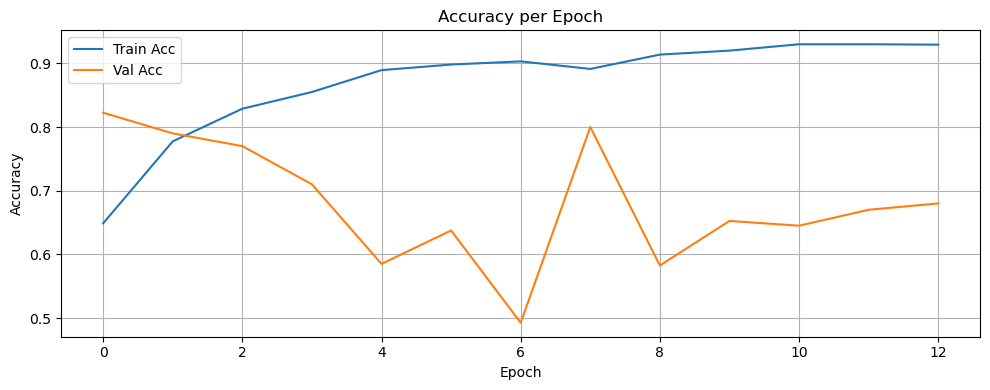

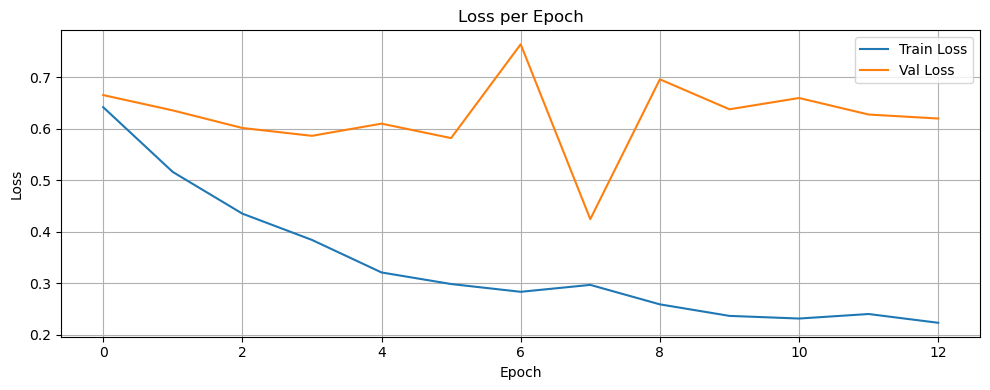

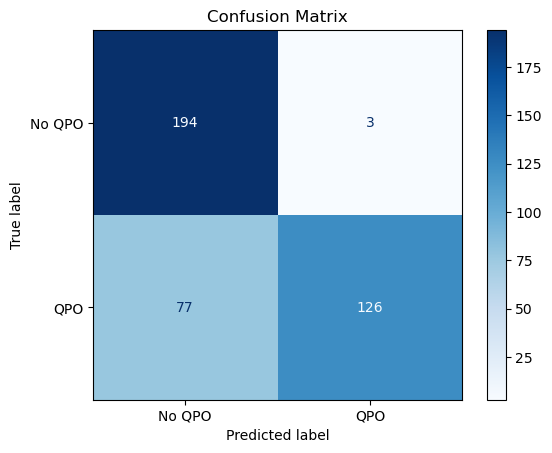

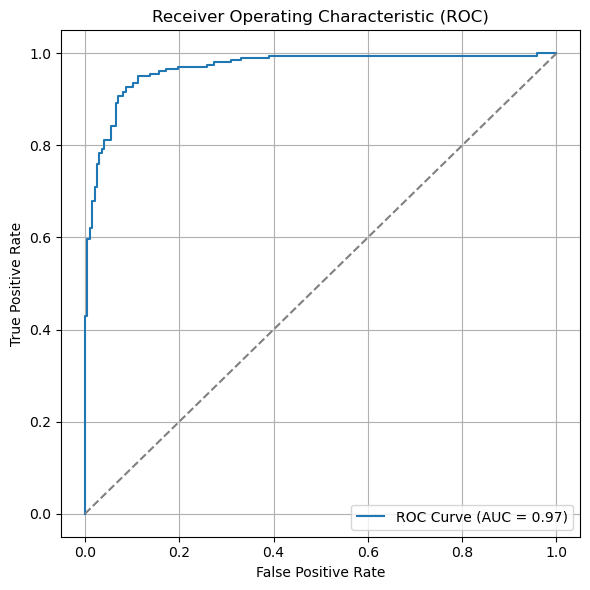

✅ Amplitude 0.2: Best Val Accuracy = 0.8225

🚀 Training on amplitude: 0.4
Epoch 1/50
13/13 - 13s - 986ms/step - accuracy: 0.7163 - loss: 0.5522 - val_accuracy: 0.7350 - val_loss: 0.6656 - learning_rate: 5.0000e-04
Epoch 2/50
13/13 - 11s - 818ms/step - accuracy: 0.8900 - loss: 0.3310 - val_accuracy: 0.5050 - val_loss: 0.6521 - learning_rate: 5.0000e-04
Epoch 3/50
13/13 - 10s - 793ms/step - accuracy: 0.9531 - loss: 0.1961 - val_accuracy: 0.5000 - val_loss: 0.6482 - learning_rate: 5.0000e-04
Epoch 4/50
13/13 - 11s - 825ms/step - accuracy: 0.9563 - loss: 0.1603 - val_accuracy: 0.5000 - val_loss: 0.6744 - learning_rate: 5.0000e-04
Epoch 5/50
13/13 - 11s - 815ms/step - accuracy: 0.9638 - loss: 0.1370 - val_accuracy: 0.4975 - val_loss: 0.7474 - learning_rate: 5.0000e-04
Epoch 6/50
13/13 - 11s - 810ms/step - accuracy: 0.9669 - loss: 0.1251 - val_accuracy: 0.5000 - val_loss: 0.7745 - learning_rate: 2.5000e-04
Epoch 7/50
13/13 - 11s - 843ms/step - accuracy: 0.9650 - loss: 0.1196 - val_accuracy: 

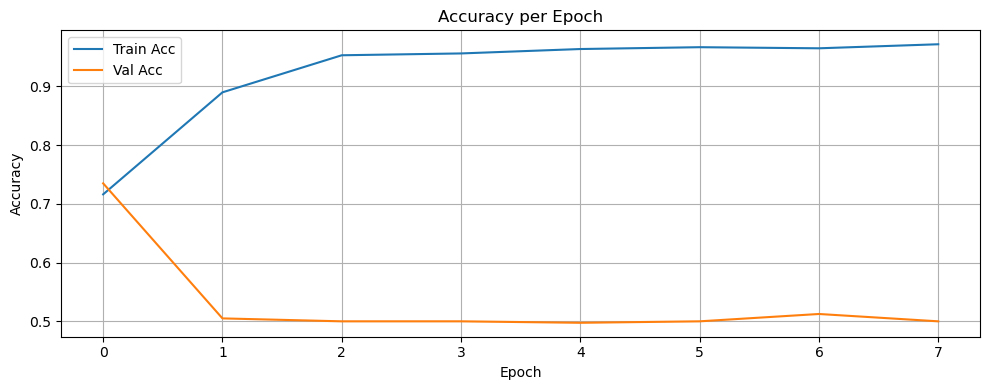

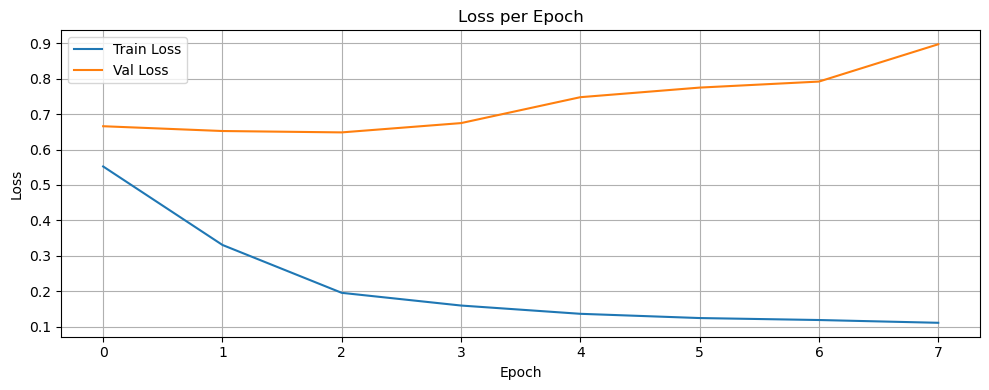

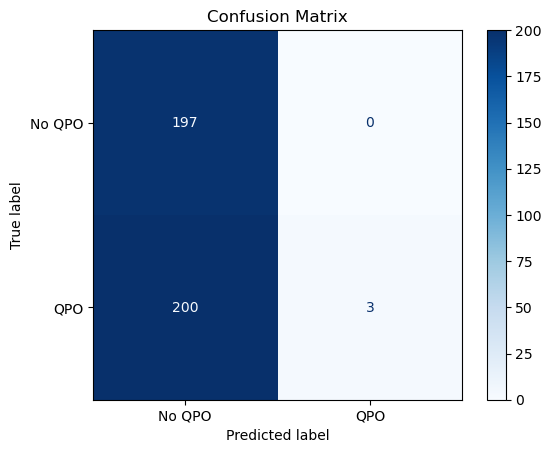

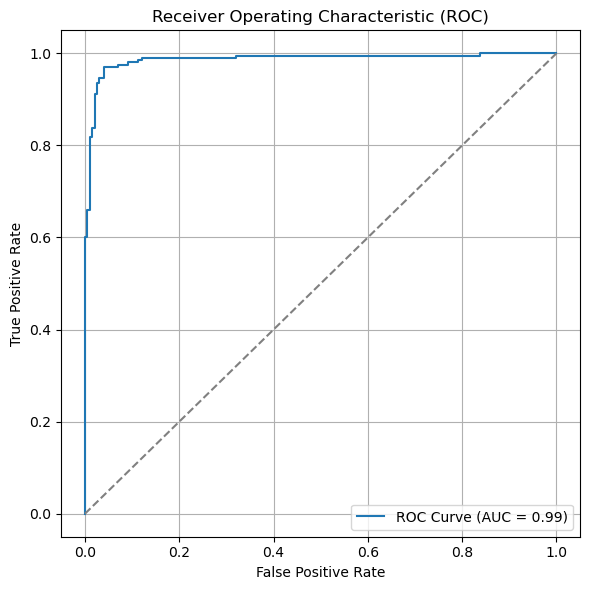

✅ Amplitude 0.4: Best Val Accuracy = 0.7350

🚀 Training on amplitude: 0.6
Epoch 1/50
13/13 - 13s - 1s/step - accuracy: 0.7269 - loss: 0.5397 - val_accuracy: 0.9725 - val_loss: 0.6207 - learning_rate: 5.0000e-04
Epoch 2/50
13/13 - 10s - 755ms/step - accuracy: 0.9231 - loss: 0.2706 - val_accuracy: 0.9150 - val_loss: 0.5609 - learning_rate: 5.0000e-04
Epoch 3/50
13/13 - 10s - 781ms/step - accuracy: 0.9650 - loss: 0.1535 - val_accuracy: 0.8125 - val_loss: 0.5002 - learning_rate: 5.0000e-04
Epoch 4/50
13/13 - 10s - 759ms/step - accuracy: 0.9812 - loss: 0.0999 - val_accuracy: 0.9000 - val_loss: 0.3677 - learning_rate: 5.0000e-04
Epoch 5/50
13/13 - 10s - 788ms/step - accuracy: 0.9781 - loss: 0.0858 - val_accuracy: 0.8800 - val_loss: 0.3375 - learning_rate: 5.0000e-04
Epoch 6/50
13/13 - 10s - 757ms/step - accuracy: 0.9825 - loss: 0.0759 - val_accuracy: 0.9025 - val_loss: 0.2912 - learning_rate: 5.0000e-04
Epoch 7/50
13/13 - 10s - 754ms/step - accuracy: 0.9812 - loss: 0.0620 - val_accuracy: 0.7

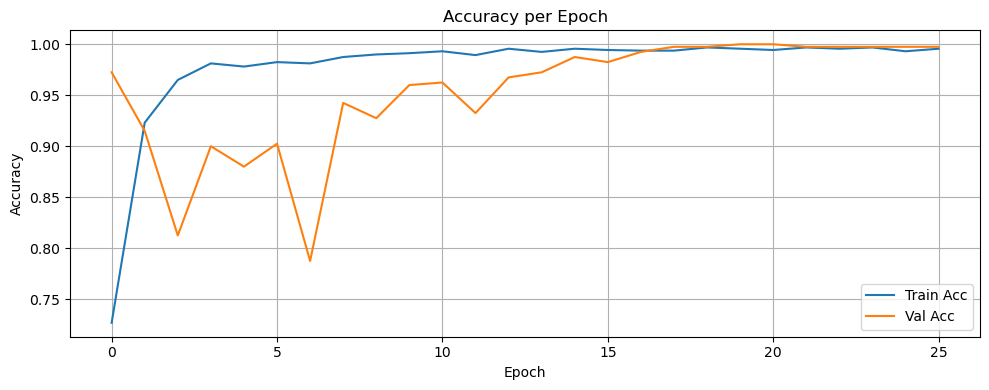

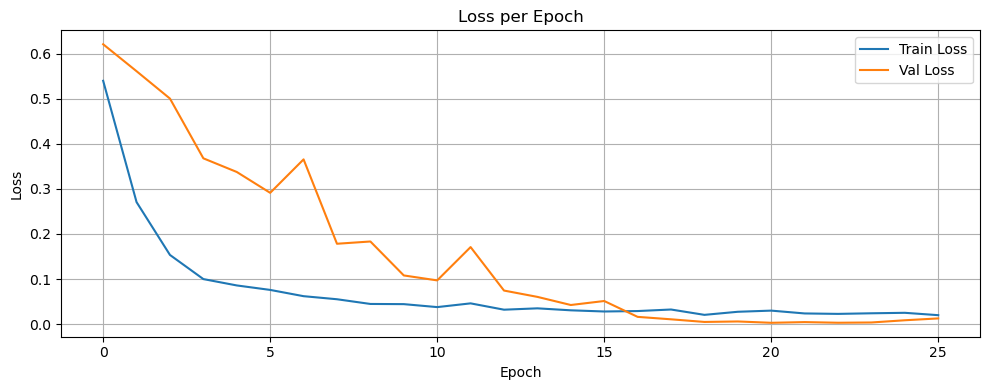

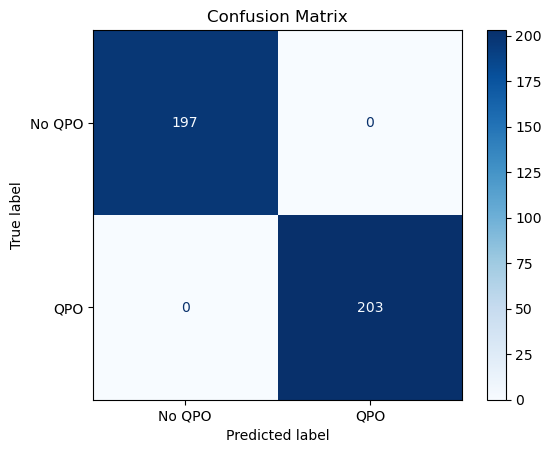

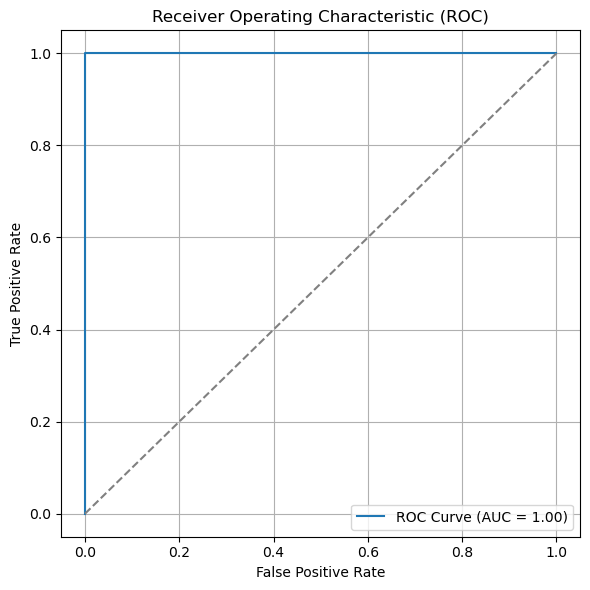

✅ Amplitude 0.6: Best Val Accuracy = 1.0000

🚀 Training on amplitude: 0.8
Epoch 1/50
13/13 - 13s - 1s/step - accuracy: 0.7431 - loss: 0.4999 - val_accuracy: 0.9825 - val_loss: 0.6013 - learning_rate: 5.0000e-04
Epoch 2/50
13/13 - 10s - 803ms/step - accuracy: 0.9337 - loss: 0.2361 - val_accuracy: 0.5825 - val_loss: 0.6166 - learning_rate: 5.0000e-04
Epoch 3/50
13/13 - 11s - 851ms/step - accuracy: 0.9675 - loss: 0.1369 - val_accuracy: 0.4925 - val_loss: 0.7004 - learning_rate: 5.0000e-04
Epoch 4/50
13/13 - 10s - 800ms/step - accuracy: 0.9812 - loss: 0.0866 - val_accuracy: 0.4925 - val_loss: 0.7621 - learning_rate: 2.5000e-04
Epoch 5/50
13/13 - 11s - 816ms/step - accuracy: 0.9844 - loss: 0.0816 - val_accuracy: 0.4925 - val_loss: 0.8477 - learning_rate: 2.5000e-04
Epoch 6/50
13/13 - 10s - 794ms/step - accuracy: 0.9887 - loss: 0.0613 - val_accuracy: 0.4925 - val_loss: 0.8906 - learning_rate: 1.2500e-04


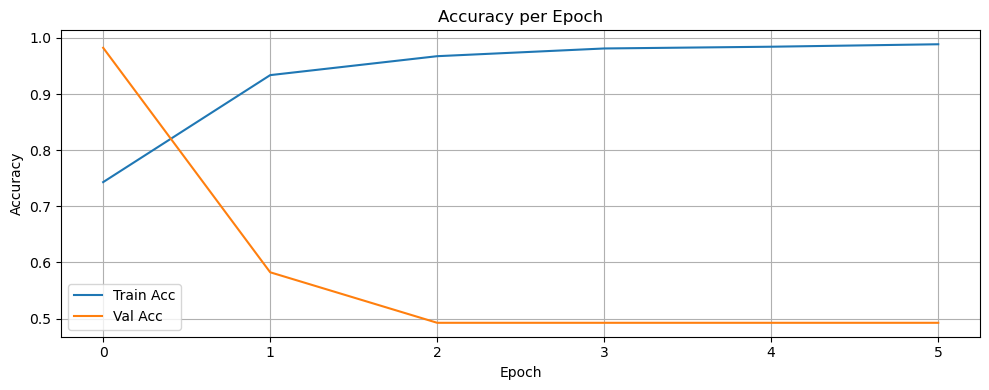

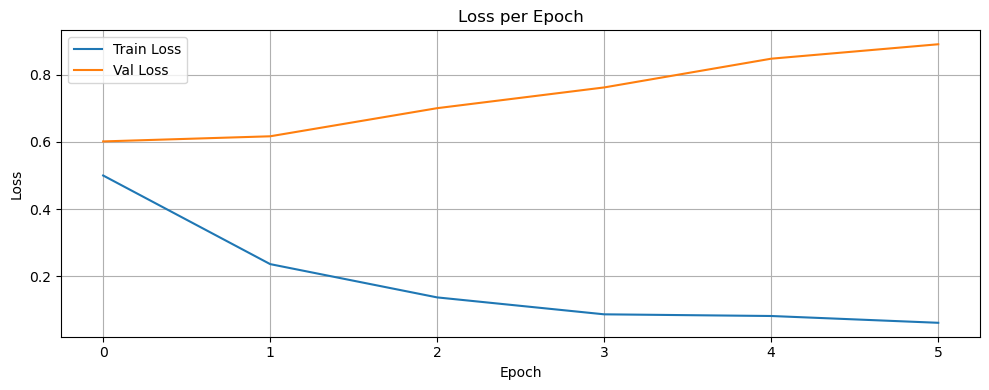

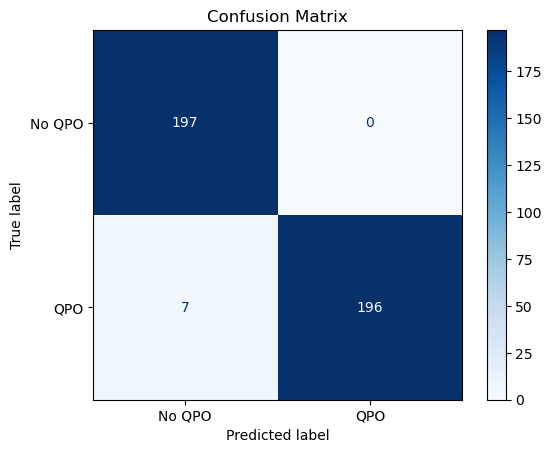

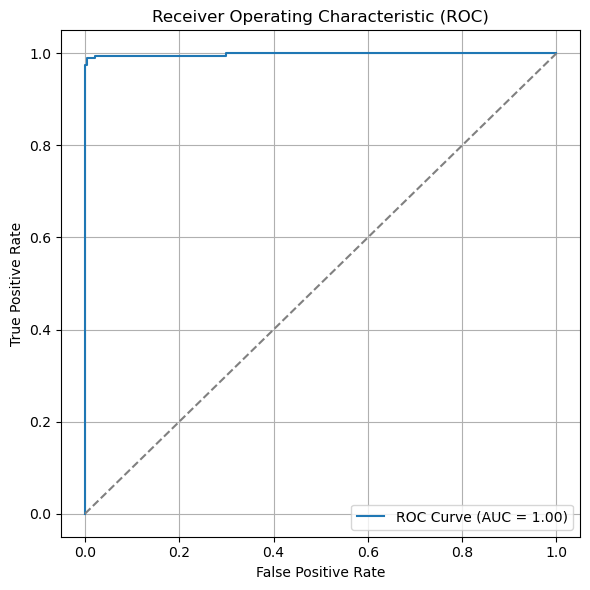

✅ Amplitude 0.8: Best Val Accuracy = 0.9825

🚀 Training on amplitude: 1.0
Epoch 1/50
13/13 - 13s - 992ms/step - accuracy: 0.7619 - loss: 0.5041 - val_accuracy: 0.9700 - val_loss: 0.5838 - learning_rate: 5.0000e-04
Epoch 2/50
13/13 - 10s - 805ms/step - accuracy: 0.9406 - loss: 0.2034 - val_accuracy: 0.8800 - val_loss: 0.5241 - learning_rate: 5.0000e-04
Epoch 3/50
13/13 - 11s - 828ms/step - accuracy: 0.9769 - loss: 0.1110 - val_accuracy: 0.8700 - val_loss: 0.4440 - learning_rate: 5.0000e-04
Epoch 4/50
13/13 - 10s - 790ms/step - accuracy: 0.9906 - loss: 0.0673 - val_accuracy: 0.8875 - val_loss: 0.3689 - learning_rate: 5.0000e-04
Epoch 5/50
13/13 - 10s - 789ms/step - accuracy: 0.9900 - loss: 0.0516 - val_accuracy: 0.8950 - val_loss: 0.3161 - learning_rate: 5.0000e-04
Epoch 6/50
13/13 - 11s - 816ms/step - accuracy: 0.9931 - loss: 0.0461 - val_accuracy: 0.8900 - val_loss: 0.3005 - learning_rate: 5.0000e-04
Epoch 7/50
13/13 - 11s - 811ms/step - accuracy: 0.9919 - loss: 0.0413 - val_accuracy: 

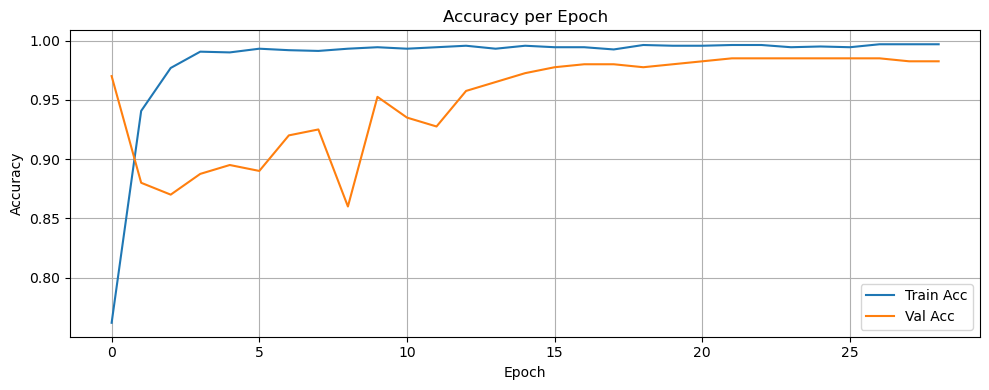

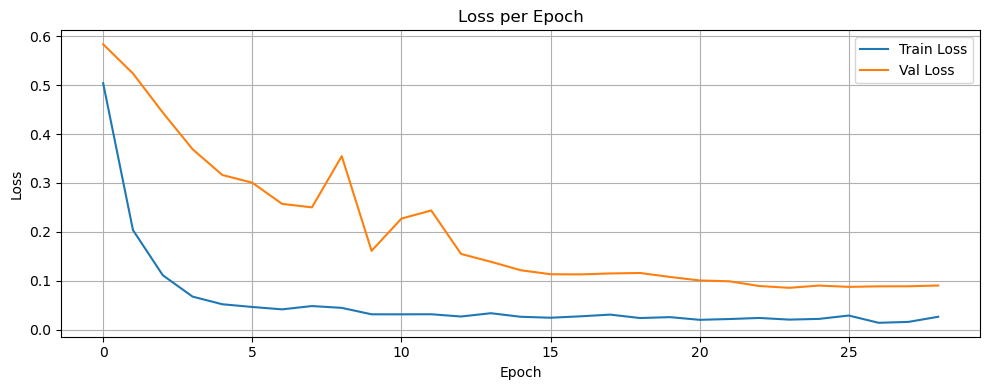

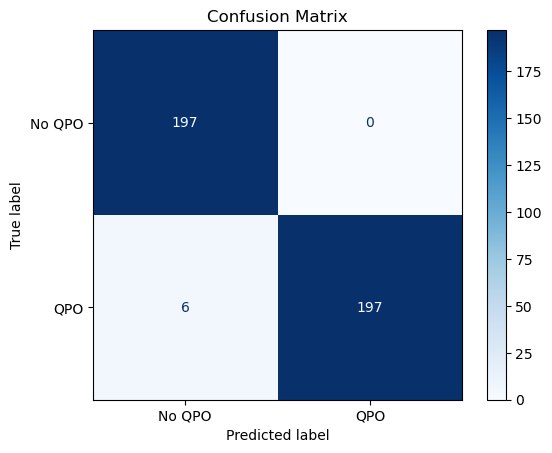

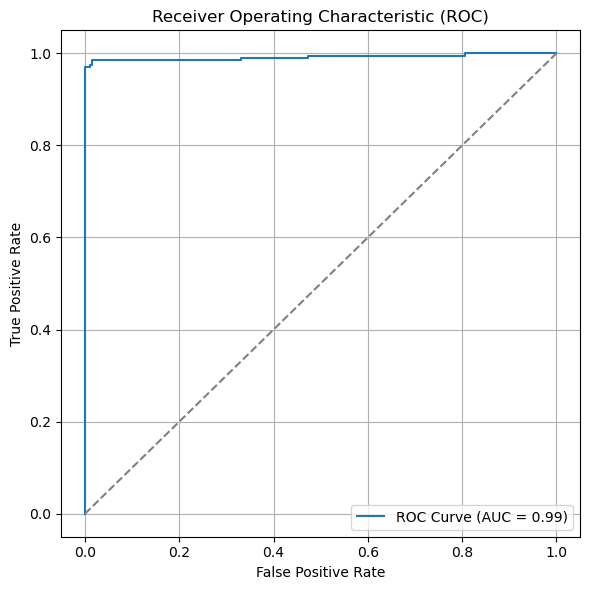

✅ Amplitude 1.0: Best Val Accuracy = 0.9850


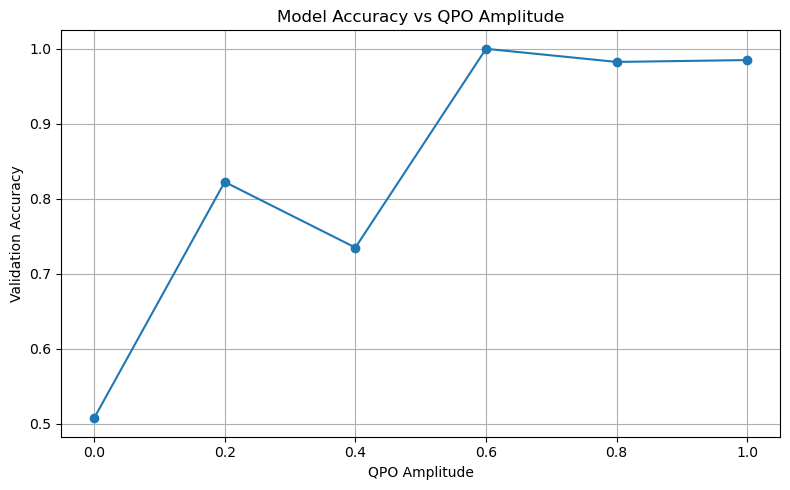

In [29]:


# --- 4. Training Loop for All Amplitudes ---
results = []
amplitudes = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for amp in amplitudes:
    print(f"\n🚀 Training on amplitude: {amp}")
    folder = f"qpo_experiments/dataset_amp_{amp}"
    generate_dataset_for_amplitude(amp, folder)

    data = np.load(os.path.join(folder, 'data.npz'))
    X, y = data['X'], data['y']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    model = build_model()

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, verbose=0)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=128,
        callbacks=[early_stopping, lr_scheduler],
        verbose=2
    )
    plot_accuracy(history=history)
    plot_loss(history=history)
    y_true, y_pred = plot_confusion_matrix(
        model=model, X_test=X_test, y_test=y_test)
    plot_roc_curve(y_true=y_true, y_pred=y_pred)

    best_val_acc = max(history.history['val_accuracy'])
    results.append((amp, best_val_acc))
    print(f"✅ Amplitude {amp}: Best Val Accuracy = {best_val_acc:.4f}")

# Save results
df_results = pd.DataFrame(results, columns=['Amplitude', 'Val_Accuracy'])
df_results.to_csv("qpo_experiments/results.csv", index=False)

# --- 5. Plot Results ---
plt.figure(figsize=(8, 5))
plt.plot(df_results['Amplitude'],
         df_results['Val_Accuracy'], marker='o', linestyle='-')
plt.xlabel("QPO Amplitude")
plt.ylabel("Validation Accuracy")
plt.title("Model Accuracy vs QPO Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()